# MVP 03 - Engenharia de Dados

## Objetivos do MVP

1. Este MVP tem como principal objetivo o desenvolvimento de um pipeline ETL (Extract, Transform and Load) robusto e escalável, implementando uma solução end-to-end (E2E) para integração de dados entre um servidor SFTP e um banco de dados PostgreSQL.

2. O pipeline será responsável pela extração automatizada de arquivos no formato .txt, que seguem uma estrutura padronizada e contêm informações cruciais relacionadas às transações financeiras processadas de uma das principais adquirentes de cartão do Supermercado analisado.

3. Por fim, esse pipeline é usado como uma das etapas do serviço de conciliação financeira que permitirá o controle das transações do Supermercado.

Escolha de tecnologias:

- Foi escolhido o uso do PostgreSQL e do armazenamento no Google Drive por motivos de custo, simplicidade e agilidade no desenvolvimento. Dado o tamanho reduzido do MVP e os custos associados a outras plataformas (AWS, GCP ou Databricks), optou-se por uma solução mais econômica e igualmente funcional, sem comprometer a qualidade técnica e os requisitos do projeto.

## Tryout - Exemplo de aplicação para fins de testes

### Importação de pacotes

In [1]:
import os
import pandas as pd
import psycopg2
from dotenv import load_dotenv
load_dotenv()
import sys
sys.path.append(r'C:\Users\ediva\OneDrive\Documentos\VS Code\aca_so\git_acaso\mvp_03_postgratudation')
from scripts.leitor_extratos import (
    process_file,
    prepare_dimension_tables
)
from scripts.reading_files import ExtratoTransacao
from scripts.transform_files import TransformerTrasacoes
from scripts.connection_db import (
    insert_df_to_db,
    delete_file_data
)

connection_params = {
    'host': os.getenv('DB_HOST'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME'),
    'port': os.getenv('DB_PORT')
}

### Leitura dos dados brutos

In [2]:
teste_file = 'EXTRATO_UNICA_51309_20240917_00003'
extrato = ExtratoTransacao(file_path=r'..\data\EXTRATO_UNICA_51309_20240917_00003')
df_header, df_transacoes, df_trailer = extrato.process_file()

print("\nInformações do Header:")
display(df_header[['codigo_registro', 'versao_layout', 'data_geracao', 'tipo_processamento']].iloc[0])

print("\nPrimeiras transações:")
display(df_transacoes.head())

print("\nInformações do Trailer:")
display(df_trailer[['total_registros']].iloc[0])


Informações do Header:


codigo_registro             A0
versao_layout           002.0a
data_geracao          20240917
tipo_processamento           N
Name: 0, dtype: object


Primeiras transações:


,codigo_registro,identificacao_loja,nsu_host_transacao,data_transacao,horario_transacao,tipo_lancamento,data_lancamento,tipo_produto,meio_captura,valor_bruto_venda,...,data_vencimento_original,indicador_deb_balance,indicador_reenvio,nsu_origem,reservado_final,numero_operacao_recebivel,sequencial_operacao_recebivel,tipo_operacao_recebivel,valor_operacao_recebivel,nseq
0,CV,008935303000108,000190825603,20240916,000000,0,20241017,C,3,34.00,...,20241017,,,000031,,,00,,0.00,000003
1,CV,008935303000108,000190839036,20240916,000000,0,20241017,C,3,73.29,...,20241017,,,000032,,,00,,0.00,000004
2,CV,008935303000108,000190850566,20240916,000000,0,20241017,C,3,38.54,...,20241017,,,160042,,,00,,0.00,000005
3,CV,008935303000108,000190853893,20240916,000000,0,20241017,C,3,25.98,...,20241017,,,160043,,,00,,0.00,000006
4,CV,008935303000108,000190970775,20240916,000000,0,20241017,C,3,10.00,...,20241017,,,160063,,,00,,0.00,000007



Informações do Trailer:


total_registros    000195
Name: 0, dtype: object

### Transformação e Validação

In [3]:
df_transacoes['file_name'] = 'EXTRATO_UNICA_51309_20240917_00003'

transformer = TransformerTrasacoes(dataframe=df_transacoes)
df_transacoes_validated = transformer.validate_all()

if isinstance(df_transacoes_validated, list):
    print("\nErros encontrados:")
    for erro in df_transacoes_validated:
        print(f"- {erro}")
else:
    print("\nValidação concluída com sucesso!")
    print(f"Total de registros validados: {len(df_transacoes_validated)}")

Todas as validações passaram.

Validação concluída com sucesso!
Total de registros validados: 191


### Inserção no banco

> disclaimer: para fins de testes será feito um processo com um schema em ambiente de desenvolvimento, com o mesmo arquivo sendo feito a deleção do banco e depois a inserção para teste do pipeline.

#### Preparando as dimensões

In [4]:
df_tempo, df_loja, df_produto, df_pagamento = prepare_dimension_tables(df_transacoes_validated)

print("Dimensões preparadas:")
print(f"Tempo: {len(df_tempo)} registros únicos")
print(f"Loja: {len(df_loja)} registros únicos") 
print(f"Produto: {len(df_produto)} registros únicos")
print(f"Pagamento: {len(df_pagamento)} registros únicos")

Dimensões preparadas:
Tempo: 6 registros únicos
Loja: 1 registros únicos
Produto: 6 registros únicos
Pagamento: 3 registros únicos


#### Deletando file tryout

In [7]:
print("\n1. Deletando dados existentes...")
if delete_file_data(**connection_params, file_name=teste_file):
    print("✓ Dados deletados com sucesso")
else:
    print("✗ Erro ao deletar dados")


1. Deletando dados existentes...
✓ Dados deletados com sucesso


#### Inserindo file tryout

In [8]:
test_file = 'EXTRATO_UNICA_51309_20240917_00003'
file_path = f'../data/{test_file}'
process_file(file_name=test_file,
             local_file_path=file_path,
             google_drive_path=os.path.join(os.getenv('GOOGLE_DRIVE_DIRECTORY'), test_file),
             connection_params=connection_params,
             is_tryout=True
             )

Todas as validações passaram.


True

## Análises após processamento 

(usando a modelagem definida e o problemas de negócios a serem analisados)

In [2]:
from scripts.analysis import (
    calculate_mdr_by_produto,
    plot_mdr_by_produto,
    simulate_mdr_by_product
)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

C:\Users\ediva\OneDrive\Documentos\VS Code\aca_so\git_acaso\mvp_03_postgratudation\scripts\analysis.py:110: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,codigo_produto,descricao,total_transacoes,valor_total,valor_liquido,mdr_percentual
0,Elo Crédito,Elo Crédito,169,13444.59,13177.72,1.984962
1,Visa Crédito,Visa Crédito,1631,170165.76,166884.28,1.928402
2,Master Crédito,Master Crédito,3137,273505.59,268247.97,1.922308
3,Elo Débito,Elo Débito,603,32869.53,32590.78,0.848050
4,Outros,Outros,679,17772.06,17621.57,0.846779
5,Master Débito,Master Débito,1504,52816.03,52382.87,0.820130
6,Visa Débito,Visa Débito,1084,51809.33,51385.19,0.818656


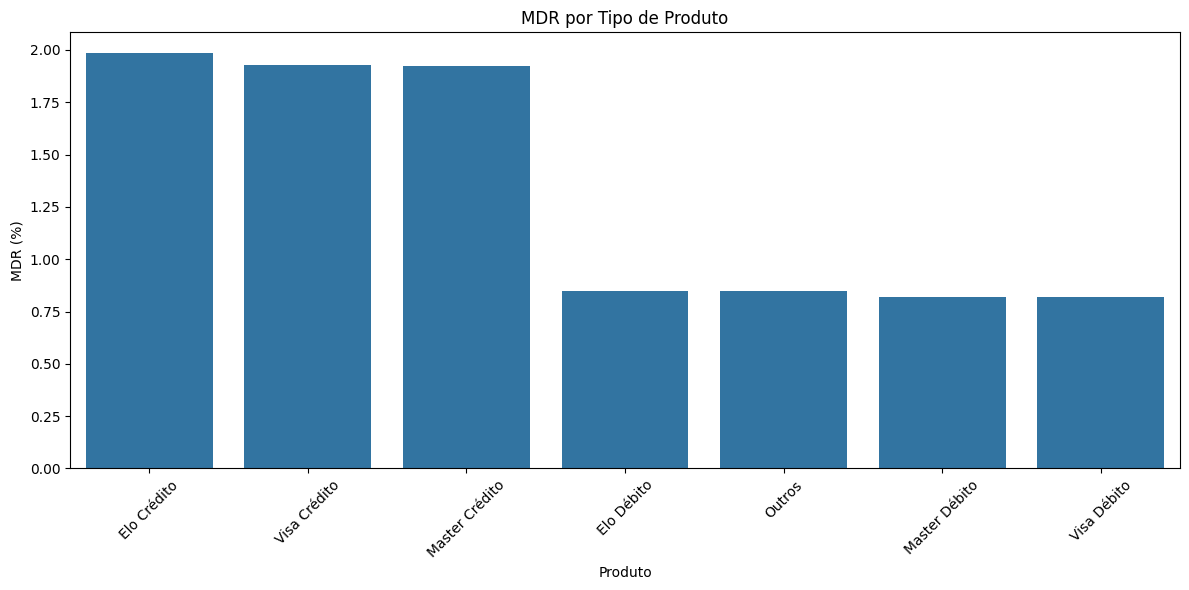

In [3]:
mdr_produto = calculate_mdr_by_produto(connection_params)
display(mdr_produto)
plot_mdr_by_produto(mdr_produto)

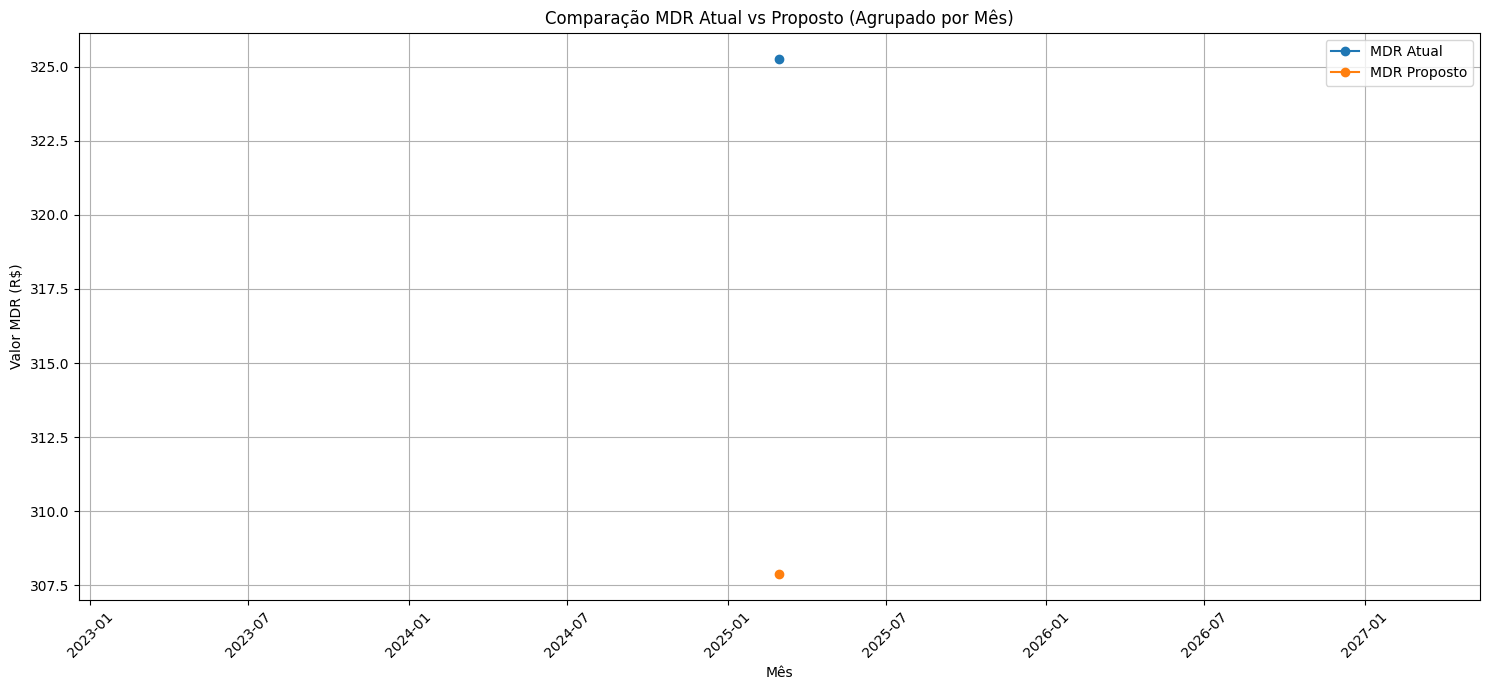

,mes,codigo_produto,tipo_pagamento,tipo_parcelamento,total_transacoes,volume_total,mdr_atual,mdr_proposto,diferenca_mdr
0,2025-03-01,Elo Crédito,Normal,a_vista,6,178.05,3.24,3.24000,0.00000
1,2025-03-01,Elo Débito,Normal,a_vista,39,1697.11,13.58,13.58000,0.00000
2,2025-03-01,Master Crédito,Normal,a_vista,84,4719.40,85.90,70.79100,-15.10900
3,2025-03-01,Master Crédito,Normal,parcelado,15,4033.28,80.67,76.63232,-4.03768
4,2025-03-01,Master Débito,Normal,a_vista,32,897.16,7.22,8.97160,1.75160
5,2025-03-01,Outros,Normal,a_vista,113,2758.18,23.03,23.03000,0.00000
6,2025-03-01,Visa Crédito,Normal,a_vista,43,2325.07,42.31,42.31000,0.00000
7,2025-03-01,Visa Crédito,Normal,parcelado,18,2247.12,44.96,44.96000,0.00000
8,2025-03-01,Visa Débito,Normal,a_vista,84,3042.10,24.36,24.36000,0.00000


In [4]:
taxas = {
    "Master Crédito": {
        "parcelado": {
            "mdr_percentual": 1.9  # 1.9%
        },
        "a_vista": {
            "mdr_percentual": 1.5  # 1.5%
        }
    },
    "Master Débito": {
        "a_vista": {
            "mdr_percentual": 1.0  # 1.0%
        }
    }
}

simulacao, impacto_total = simulate_mdr_by_product(
    connection_params=connection_params,
    taxas_json=taxas
)

display(simulacao)